In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import yfinance as yf
import pandas as pd
import numpy as np
from src.gpu.simulation_based_tree import SimulationBasedModel
from src.simulations import PathSimulator
import torch
from datetime import datetime
from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns
from copy import deepcopy

## Calibration of models


In [3]:


def fetch_options(ticker : str):
    # Initialize the AAPL stock object
    aapl = yf.Ticker(ticker)
    
    # Fetch available option expiration dates
    expiration_dates = aapl.options

    # Initialize a DataFrame to store all options data
    all_options = pd.DataFrame()

    # Loop over each expiration date and fetch the option chain
    for date in expiration_dates:
        # Fetch options for this expiration date
        options_chain = aapl.option_chain(date)
        
        # Combine calls and puts into one DataFrame with an expiration date column
        calls = options_chain.calls
        calls['type'] = 'call'
        calls['expirationDate'] = pd.to_datetime(date)

        puts = options_chain.puts
        puts['type'] = 'put'
        puts['expirationDate'] = pd.to_datetime(date)

        # Concatenate calls and puts
        all_options = pd.concat([all_options, calls, puts])

    return all_options.reset_index(drop=True)


In [4]:
aapl_options = fetch_options('AAPL')
aapl_options['lastTradeDay'] = pd.to_datetime(aapl_options.lastTradeDate.dt.date)
aapl_options = aapl_options[~aapl_options.volume.isna()]
aapl_options['option_price'] = aapl_options['lastPrice']#(aapl_options['bid']+aapl_options['ask'])/2
aapl_options['T'] = aapl_options.apply(lambda x: (len(pd.bdate_range(x['lastTradeDay'], x['expirationDate'])) - 1)/252, axis = 1)
aapl_options.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,expirationDate,lastTradeDay,option_price,T
0,AAPL241122C00100000,2024-11-18 14:55:12+00:00,100.0,126.98,0.0,0.0,0.0,0.0,1.0,0.0,0.00001,True,REGULAR,USD,call,2024-11-22,2024-11-18,126.98,0.015873
2,AAPL241122C00130000,2024-11-18 17:59:33+00:00,130.0,99.15,0.0,0.0,0.0,0.0,3.0,4.0,0.00001,True,REGULAR,USD,call,2024-11-22,2024-11-18,99.15,0.015873
3,AAPL241122C00135000,2024-11-08 20:24:06+00:00,135.0,92.99,0.0,0.0,0.0,0.0,3.0,4.0,0.00001,True,REGULAR,USD,call,2024-11-22,2024-11-08,92.99,0.039683
4,AAPL241122C00140000,2024-11-15 15:50:11+00:00,140.0,84.82,0.0,0.0,0.0,0.0,8.0,0.0,0.00001,True,REGULAR,USD,call,2024-11-22,2024-11-15,84.82,0.019841
5,AAPL241122C00145000,2024-11-15 15:39:53+00:00,145.0,80.08,0.0,0.0,0.0,0.0,3.0,8.0,0.00001,True,REGULAR,USD,call,2024-11-22,2024-11-15,80.08,0.019841


In [5]:
start_date = aapl_options['lastTradeDay'].min()
end_date = aapl_options['lastTradeDay'].max()

In [6]:
str(end_date.date())

'2024-11-18'

In [25]:
aapl_prices = yf.download("AAPL", start = str(start_date.date()), end = str(datetime.today().date()))\
    [['Close']]\
    .droplevel(level = 0, axis = 1)
aapl_prices.columns = ['underlying_price']

[*********************100%***********************]  1 of 1 completed


In [27]:
aapl_prices.index = aapl_prices.index.tz_localize(None)

In [28]:
aapl_options = aapl_options.sort_values("lastTradeDate")

In [29]:
aapl_options = pd.merge_asof(
    aapl_options,
    aapl_prices,
    left_on='lastTradeDay',
    right_index=True,
    allow_exact_matches=True
)

In [30]:
aapl_options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,inTheMoney,contractSize,currency,type,expirationDate,lastTradeDay,option_price,T,AAPL,underlying_price
1035,AAPL250620P00310000,2024-03-21 15:02:24+00:00,310.0,137.30,144.10,146.50,0.0,0.0,4.0,0.0,...,True,REGULAR,USD,put,2025-06-20,2024-03-21,137.30,1.293651,171.369995,171.369995
568,AAPL250117P00010000,2024-04-11 18:44:15+00:00,10.0,0.01,0.00,0.01,0.0,0.0,47.0,273.0,...,False,REGULAR,USD,put,2025-01-17,2024-04-11,0.01,0.797619,175.039993,175.039993
331,AAPL241220C00085000,2024-05-07 19:29:13+00:00,85.0,99.84,111.30,112.95,0.0,0.0,5.0,218.0,...,True,REGULAR,USD,call,2024-12-20,2024-05-07,99.84,0.646825,182.399994,182.399994
1383,AAPL251219P00310000,2024-05-22 19:44:00+00:00,310.0,118.77,100.60,104.50,0.0,0.0,5.0,0.0,...,True,REGULAR,USD,put,2025-12-19,2024-05-22,118.77,1.634921,190.899994,190.899994
497,AAPL250117C00035000,2024-06-04 18:28:19+00:00,35.0,161.27,187.05,187.80,0.0,0.0,4.0,3.0,...,True,REGULAR,USD,call,2025-01-17,2024-06-04,161.27,0.646825,194.350006,194.350006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,AAPL250221C00230000,2024-11-18 20:59:59+00:00,230.0,10.85,0.00,0.00,0.0,0.0,975.0,6204.0,...,False,REGULAR,USD,call,2025-02-21,2024-11-18,10.85,0.273810,228.020004,228.020004
80,AAPL241122P00225000,2024-11-18 20:59:59+00:00,225.0,0.98,0.00,0.00,0.0,0.0,28464.0,0.0,...,False,REGULAR,USD,put,2024-11-22,2024-11-18,0.98,0.015873,228.020004,228.020004
658,AAPL250221C00225000,2024-11-18 20:59:59+00:00,225.0,11.55,0.00,0.00,0.0,0.0,216.0,4403.0,...,True,REGULAR,USD,call,2025-02-21,2024-11-18,11.55,0.273810,228.020004,228.020004
130,AAPL241129C00235000,2024-11-18 20:59:59+00:00,235.0,0.72,0.00,0.00,0.0,0.0,7260.0,7144.0,...,False,REGULAR,USD,call,2024-11-29,2024-11-18,0.72,0.035714,228.020004,228.020004


In [31]:
aapl_options[['underlying_price']]

,underlying_price
1035,171.369995
568,175.039993
331,182.399994
1383,190.899994
497,194.350006
...,...
659,228.020004
80,228.020004
658,228.020004
130,228.020004


In [32]:
aapl_options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,inTheMoney,contractSize,currency,type,expirationDate,lastTradeDay,option_price,T,AAPL,underlying_price
1035,AAPL250620P00310000,2024-03-21 15:02:24+00:00,310.0,137.30,144.10,146.50,0.0,0.0,4.0,0.0,...,True,REGULAR,USD,put,2025-06-20,2024-03-21,137.30,1.293651,171.369995,171.369995
568,AAPL250117P00010000,2024-04-11 18:44:15+00:00,10.0,0.01,0.00,0.01,0.0,0.0,47.0,273.0,...,False,REGULAR,USD,put,2025-01-17,2024-04-11,0.01,0.797619,175.039993,175.039993
331,AAPL241220C00085000,2024-05-07 19:29:13+00:00,85.0,99.84,111.30,112.95,0.0,0.0,5.0,218.0,...,True,REGULAR,USD,call,2024-12-20,2024-05-07,99.84,0.646825,182.399994,182.399994
1383,AAPL251219P00310000,2024-05-22 19:44:00+00:00,310.0,118.77,100.60,104.50,0.0,0.0,5.0,0.0,...,True,REGULAR,USD,put,2025-12-19,2024-05-22,118.77,1.634921,190.899994,190.899994
497,AAPL250117C00035000,2024-06-04 18:28:19+00:00,35.0,161.27,187.05,187.80,0.0,0.0,4.0,3.0,...,True,REGULAR,USD,call,2025-01-17,2024-06-04,161.27,0.646825,194.350006,194.350006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,AAPL250221C00230000,2024-11-18 20:59:59+00:00,230.0,10.85,0.00,0.00,0.0,0.0,975.0,6204.0,...,False,REGULAR,USD,call,2025-02-21,2024-11-18,10.85,0.273810,228.020004,228.020004
80,AAPL241122P00225000,2024-11-18 20:59:59+00:00,225.0,0.98,0.00,0.00,0.0,0.0,28464.0,0.0,...,False,REGULAR,USD,put,2024-11-22,2024-11-18,0.98,0.015873,228.020004,228.020004
658,AAPL250221C00225000,2024-11-18 20:59:59+00:00,225.0,11.55,0.00,0.00,0.0,0.0,216.0,4403.0,...,True,REGULAR,USD,call,2025-02-21,2024-11-18,11.55,0.273810,228.020004,228.020004
130,AAPL241129C00235000,2024-11-18 20:59:59+00:00,235.0,0.72,0.00,0.00,0.0,0.0,7260.0,7144.0,...,False,REGULAR,USD,call,2024-11-29,2024-11-18,0.72,0.035714,228.020004,228.020004


## Train-test split

In [33]:
L = len(aapl_options)
train_df = aapl_options

In [54]:
t = train_df['T'].value_counts().index[7]

In [55]:
Ks = train_df.query(f"T == {t} & type == 'call'").strike
px = train_df.query(f"T == {t} & type == 'call'").option_price


In [56]:
df = pd.concat([Ks, px], axis = 1).sort_values("strike")
Ks, px = df['strike'], df['option_price']

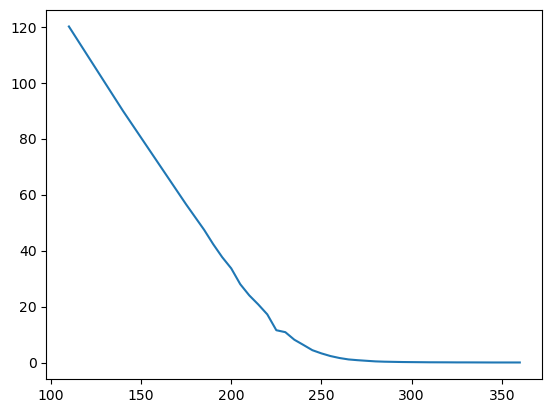

In [57]:
import matplotlib.pyplot as plt

plt.plot(Ks, px)

## Calibrating

In [68]:
# initial_params = torch.Tensor([0.1,0.1, 0.01, 0.1, 0.1, 0.1],).to('cuda') #rho, kappa, theta, v0, s0, eta, r
# initial_params.requires_grad = True
# optimizer = torch.optim.Adam([initial_params], lr=0.01)
device = 'cuda'
import gc
simulator = PathSimulator()

import torch.nn.functional as F

rho = torch.nn.Parameter(torch.atanh(torch.tensor(-0.5)))    # Correlation rho in [-1, 1]
kappa = torch.nn.Parameter(torch.tensor(5.0))    # Mean reversion rate, ensure positivity
theta = torch.nn.Parameter(torch.tensor(0.16))              # Long-run variance, positive
v0 = torch.nn.Parameter(torch.tensor(0.25**2))                 # Initial variance, set equal to theta
eta = torch.nn.Parameter(torch.tensor(0.9))                 # Volatility of volatility, positive
r = torch.nn.Parameter(torch.tensor(0.1))      

params = [rho, kappa, theta, v0, eta, r]
optimizer = torch.optim.Adam(params, lr=1e-2)

def transformed_params(rho, kappa, theta, v0, eta, r):
    # [-1, 1] range: scaled tanh (less extreme than directly using torch.tanh)
    rho_ = torch.tanh(rho)   # Slightly scaled to avoid extremes

    # [0, 1] range: sigmoid with slight scaling
    kappa_ = F.softplus(kappa)  # Ensures values are in (0.01, 0.99)
    r_ = F.softplus(r)         # Same for r to avoid edges
    
    # Positive range: softplus (less extreme than exp)
    theta_ = F.softplus(theta) + 1e-6            # Ensures positive values, avoids zero
    v0_ = F.softplus(v0) + 1e-6                  # Ensures positive values, avoids zero
    eta_ = F.softplus(eta) + 1e-6                # Ensures positive values, avoids zero

    # Feller condition for eta: eta <= sqrt(2 * kappa * theta)
    eta_ = torch.min(eta_, torch.sqrt(2 * kappa_ * theta_))

    return rho_, kappa_, theta_, v0_, eta_, r_

# Apply transformations in the forward pass

n = 50
m = 500*n

losses = []

# Optimization loop
num_iterations = 100
batch_size = 64
memo = {}

best_params = None
best_index = None
best_loss = float('inf')

# with torch.autograd.set_detect_anomaly(True):
for iteration in range(num_iterations):

    optimizer.zero_grad()

    rho_, kappa_, theta_, v0_, eta_, r_ = transformed_params(rho, kappa, theta, v0, eta, r)
    print([rho_, kappa_, theta_, v0_, eta_, r_])


    stochastic_df = train_df.query("type == 'put'").sample(batch_size)
    batch_size = len(stochastic_df)
    model_prices = torch.zeros(len(stochastic_df), device=device)
    market_prices = torch.zeros(len(stochastic_df), device=device)
    Ks = torch.zeros(len(stochastic_df), device=device)
    # rho, kappa, theta, v0, eta, r = initial_params
    # batch_loss = (rho**2 + kappa**2 + theta**2 + v0**2 + eta**2 + r**2) 


    for i, (idx, row) in tqdm(enumerate(stochastic_df.iterrows()), total = len(stochastic_df)):
        T = row['T']
        option_type = row['type']
        market_price = row['option_price']
        S0 = row['underlying_price']
        K = row['strike']


        if option_type == 'call':
            g= lambda x, k: torch.maximum(x-k, torch.tensor(0))

        elif option_type == 'put':
        
            g= lambda x, k: torch.maximum(k-x, torch.tensor(0))

        pricer = SimulationBasedModel(n,row['strike'], r_, T/n, option_type='american', model = 'heston', device=device)
        St, _ = simulator.heston_gpu(T,m,n,rho_, kappa_, theta_, v0_, S0,eta_, r_, device = device)

        
        # option_price = pricer.compute_option_prices_counting(St, g)


        M, n = St.shape
        dt = T/n
        memo = {}


        for t in range(n - 1, -1, -1):

            # Compute quantile bins for current and next time steps
            bins_current, prices_t = pricer.compute_quantiles(St[:, t], t+3)

            if t == n-1:
                memo[t] = (g(prices_t[1:-1], K))
                continue

            bins_next, prices_t_next = pricer.compute_quantiles(St[:, t + 1], t+4)
            
            probabilities = pricer.compute_transition_matrix(
                bins_current, 
                bins_next,
            )


            continuation_values = probabilities @ (memo[t+1] * torch.exp(-r_* dt))

            stopping_values_all = g(prices_t[1:-1], K)
            
            # del bins_current
            # del prices_t
            # del bins_next
            # torch.cuda.empty_cache()
            # gc.collect()

            memo[t] = torch.maximum(continuation_values, stopping_values_all)

            if memo[t].isnan().any():
                break


        # Option price at time 0
        option_price = memo[0][0]

        if option_price.isnan():
            break

        model_prices[i] = option_price
        market_prices[i] = torch.tensor(market_price, device= device)
        Ks[i] = K

    


    batch_loss = ((model_prices  - market_prices)**2).sum()
    # batch_loss.requires_grad =True
    batch_loss = batch_loss / batch_size

    if batch_loss < best_loss:
        best_index = iteration
        best_loss = batch_loss
        best_parameters = deepcopy(params)

    losses.append(batch_loss.item())
    # break
    batch_loss.backward()
    optimizer.step()



    clear_output()
    print(f"Iteration {iteration + 1}/{num_iterations}, Loss: {batch_loss.item():.6f}")
    print([rho_, kappa_, theta_, v0_, eta_, r_])
    # print(rho.grad)

Iteration 100/100, Loss: 9.092180
[tensor(-0.0813, grad_fn=<TanhBackward0>), tensor(4.4776, grad_fn=<SoftplusBackward0>), tensor(0.6201, grad_fn=<AddBackward0>), tensor(0.4752, grad_fn=<AddBackward0>), tensor(1.0532, grad_fn=<MinimumBackward0>), tensor(0.9438, grad_fn=<SoftplusBackward0>)]


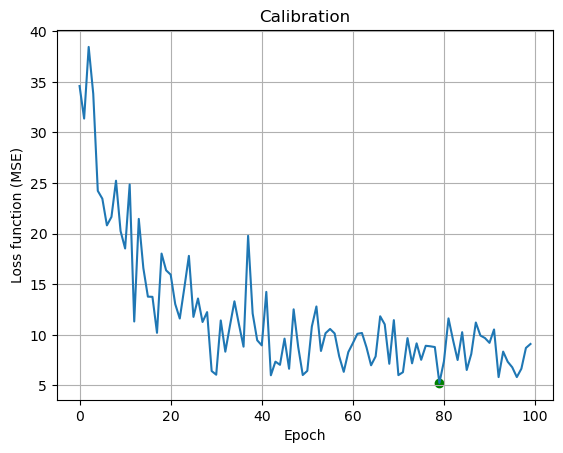

In [72]:
plt.plot(losses)
plt.scatter(best_index, losses[best_index], color = 'green',)
plt.title("Calibration")
plt.ylabel("Loss function (MSE)")
plt.xlabel("Epoch")
plt.grid()

In [73]:
best_parameters

[Parameter containing:
 tensor(-0.0995, requires_grad=True),
 Parameter containing:
 tensor(4.5139, requires_grad=True),
 Parameter containing:
 tensor(-0.1766, requires_grad=True),
 Parameter containing:
 tensor(-0.4408, requires_grad=True),
 Parameter containing:
 tensor(0.6034, requires_grad=True),
 Parameter containing:
 tensor(0.4675, requires_grad=True)]

In [74]:
rho, kappa, theta, v0, eta, r = best_parameters
rho_, kappa_, theta_, v0_, eta_, r_ = transformed_params(rho, kappa, theta, v0, eta, r)

n = 200
m = 500*n

df = train_df.query("type == 'put'")

model_prices = torch.zeros(len(df), device=device)
market_prices = torch.zeros(len(df), device=device)
Ks = torch.zeros(len(df), device=device)

with torch.no_grad():
    for i, (idx, row) in tqdm(enumerate(df.iterrows()), total = len(df)):
        T = row['T']
        option_type = row['type']
        market_price = row['option_price']
        S0 = row['underlying_price']
        K = row['strike']


        if option_type == 'call':
            g= lambda x, k: torch.maximum(x-k, torch.tensor(0))

        elif option_type == 'put':
        
            g= lambda x, k: torch.maximum(k-x, torch.tensor(0))

        pricer = SimulationBasedModel(n,row['strike'], r_, T/n, option_type='american', model = 'heston', device=device)
        St, _ = simulator.heston_gpu(T,m,n,rho_, kappa_, theta_, v0_, S0,eta_, r_, device = device)

        
        # option_price = pricer.compute_option_prices_counting(St, g)


        M, n = St.shape
        dt = T/n
        memo = {}


        for t in range(n - 1, -1, -1):

            # Compute quantile bins for current and next time steps
            bins_current, prices_t = pricer.compute_quantiles(St[:, t], t+3)

            if t == n-1:
                memo[t] = (g(prices_t[1:-1], K))
                continue

            bins_next, prices_t_next = pricer.compute_quantiles(St[:, t + 1], t+4)
            
            probabilities = pricer.compute_transition_matrix(
                bins_current, 
                bins_next,
            )


            continuation_values = probabilities @ (memo[t+1] * torch.exp(-r_* dt))

            stopping_values_all = g(prices_t[1:-1], K)
            
            # del bins_current
            # del prices_t
            # del bins_next
            # torch.cuda.empty_cache()
            # gc.collect()

            memo[t] = torch.maximum(continuation_values, stopping_values_all)

            if memo[t].isnan().any():
                break


        # Option price at time 0
        option_price = memo[0][0]

        if option_price.isnan():
            break

        model_prices[i] = option_price
        market_prices[i] = torch.tensor(market_price, device= device)
        Ks[i] = K

100%|██████████| 814/814 [04:13<00:00,  3.21it/s]


In [75]:
market_prices = market_prices.detach().cpu().numpy()
model_prices = model_prices.detach().cpu().numpy()

<Axes: ylabel='Count'>

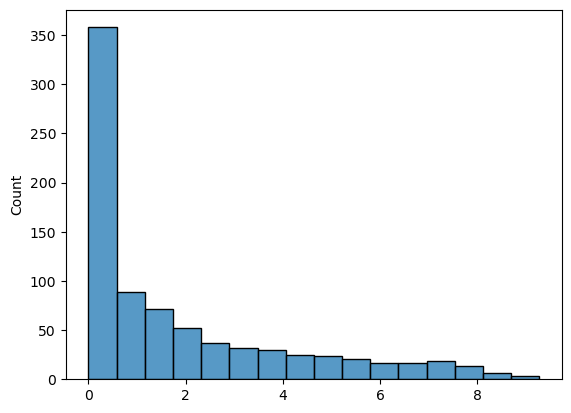

In [82]:
sns.histplot(abs(market_prices - model_prices))

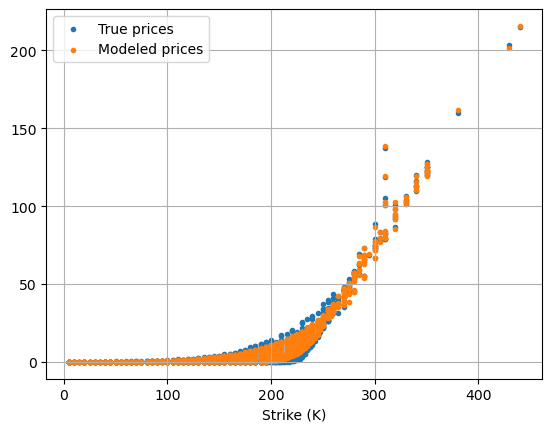

In [80]:

plt.scatter(Ks.cpu(), market_prices, marker='.', label = 'True prices')
plt.scatter(Ks.cpu(), model_prices, marker='.', label = "Modeled prices")
plt.xlabel("Strike (K)")
plt.grid()

plt.legend()